In [ ]:
###########
# IMPORTS #
###########

# I/0
from google.colab import files

# Commonly used modules
import numpy as np
import pandas as pd
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Data split through train_test_split
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.6.0


In [ ]:
############
# INSTALLS #
############

#! pip install -q kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle &> /dev/null

###########
# CLEANUP #
###########

! rm -rf /content/emails /content/email-spam-classification-dataset-csv.zip

#########
# SETUP #
#########

uploaded = files.upload()

! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
##################
# IMPORT DATASET #
##################

#! kaggle datasets list
! kaggle datasets download --force -d balaka18/email-spam-classification-dataset-csv

! mkdir -p /content/emails
! unzip /content/email-spam-classification-dataset-csv.zip -d /content/emails

  0% 0.00/1.66M [00:00<?, ?B/s]
100% 1.66M/1.66M [00:00<00:00, 118MB/s]
Archive:  /content/email-spam-classification-dataset-csv.zip
  inflating: /content/emails/emails.csv  


In [ ]:
################
# READ DATASET #
################

data = pd.read_csv('emails/emails.csv')
data[0:5]
#data.head()
data.tail()

,Email No.,the,to,ect,and,for,of,a,you,hou,in,on,is,this,enron,i,be,that,will,have,with,your,at,we,s,are,it,by,com,as,from,gas,or,not,me,deal,if,meter,hpl,please,...,bold,catch,performing,accepted,matters,batch,continuing,winning,symbol,offsystem,decisions,produced,ended,greatest,degree,solmonson,imbalances,fall,fear,hate,fight,reallocated,debt,reform,australia,plain,prompt,remains,ifhsc,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
5167,Email 5168,2,2,2,3,0,0,32,0,0,5,6,1,0,0,20,1,0,0,1,0,0,3,0,18,1,5,0,0,2,2,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5168,Email 5169,35,27,11,2,6,5,151,4,3,23,18,6,3,1,98,10,6,2,2,6,1,11,15,101,2,12,1,3,25,3,5,14,7,14,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5169,Email 5170,0,0,1,1,0,0,11,0,0,1,1,3,1,0,10,0,0,0,0,0,0,1,0,11,0,1,0,0,1,0,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5170,Email 5171,2,7,1,0,2,1,28,2,0,8,11,7,1,0,39,1,0,0,0,2,1,3,3,37,0,8,0,4,5,1,0,5,0,3,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5171,Email 5172,22,24,5,1,6,5,148,8,2,23,13,5,4,1,99,6,4,1,1,1,1,6,16,89,4,5,0,1,22,5,5,16,7,18,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#################
# DATASET STATS #
#################

data.describe()

,the,to,ect,and,for,of,a,you,hou,in,on,is,this,enron,i,be,that,will,have,with,your,at,we,s,are,it,by,com,as,from,gas,or,not,me,deal,if,meter,hpl,please,re,...,bold,catch,performing,accepted,matters,batch,continuing,winning,symbol,offsystem,decisions,produced,ended,greatest,degree,solmonson,imbalances,fall,fear,hate,fight,reallocated,debt,reform,australia,plain,prompt,remains,ifhsc,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,...,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.00000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000
mean,6.640565,6.188128,5.143852,3.075599,3.124710,2.627030,55.517401,2.466551,2.024362,10.600155,10.935808,5.386118,1.388631,1.335267,45.857889,3.229312,0.924401,0.850928,0.804718,0.939675,0.814385,6.932328,1.978732,41.811872,1.408546,4.501160,0.657386,1.767208,4.807425,0.813998,0.617363,7.749033,0.838167,5.332367,0.734532,1.225251,0.538090,0.635151,0.627804,9.109049,...,0.005994,0.005607,0.004254,0.004254,0.004640,0.008701,0.005994,0.006381,0.008894,0.00406,0.004060,0.005414,0.070766,0.004060,0.008701,0.006187,0.005800,0.017208,0.006381,0.015855,0.005800,0.004640,0.006381,0.005027,0.006961,0.037510,0.008894,0.004060,0.005220,0.005607,0.005027,0.012568,0.010634,0.098028,0.004254,0.006574,0.004060,0.914733,0.006961,0.290023
std,11.745009,9.534576,14.101142,6.045970,4.680522,6.229845,87.574172,4.314444,6.967878,19.281892,17.999402,9.144407,2.849708,4.570525,77.832221,5.045836,2.084255,2.065738,1.444839,2.036278,2.001731,12.949766,3.719254,66.530032,2.583277,8.377237,1.247460,11.002626,7.568755,1.657193,1.844452,12.538043,1.771383,8.256332,1.930954,2.375526,1.945471,1.516908,1.130827,14.494729,...,0.118664,0.077224,0.073462,0.070781,0.067969,0.210261,0.077195,0.123437,0.110895,0.08675,0.066569,0.080906,0.367953,0.066569,0.132372,0.087733,0.100112,0.191417,0.097135,0.140928,0.133259,0.073439,0.097135,0.073413,0.162025,0.239546,0.099885,0.066569,0.084428,0.192108,0.105788,0.199682,0.116693,0.569532,0.096252,0.138908,0.072145,2.780203,0.098086,0.453817
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


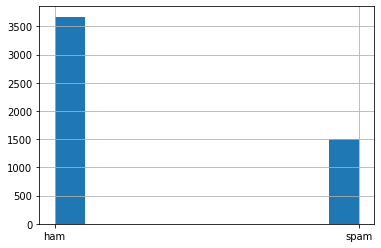

In [ ]:
#######################
# DATASET INFORMATION #
#######################

data.info()

# Print last column
# print(c)

# Print first rows
# data.head()

# Print last rows
# data.tail()

# Print a random sample of rows
# data.sample(5)

# Print statistics
#data.describe()

# data['Prediction'][1558:1559]

#data.label.hist(bins=3)
#dP=data.Prediction

bar=data.Prediction
bar.replace((1, 0), ('spam', 'ham'), inplace=True)
bar.hist(bins=10)

In [ ]:
####################
# HELPER FUNCTIONS #
####################

# Check for empty columns on a dataframe
def df_check_empty_columns(vec,name):
  print(name+':')
  cols=(vec == 0).all()
  for c in range(cols.shape[0]):
    if(cols[c]==True):
      print(c)
  print()

# Check for empty columns on a ndarray
def nd_check_empty_columns(mat):
  print((~mat.any(axis=0)).any())

In [ ]:
###############
# DUMMY TESTS #
###############

#mat=pd.DataFrame(np.random.randint(0, 2, (2, 8)))
#print(mat)

#df_check_empty_columns(mat,'mat')
#mat.iloc[:,6]

#nums = np.random.randint(0,2,(2,8))
#print(nums)
#nd_check_empty_columns(nums)

In [ ]:
##############
# DATA SETUP #
##############

# Take away first and last columns from training data
x=data.iloc[:,1:3001].astype(int)

# Specify the target labels and flatten the array 
y=np.ravel(data.type).astype(int)

# Split the data up in train and test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.08, random_state=42)

# Convert features into ndarrays
train_features=train_x.to_numpy()
train_labels=train_y

test_features=test_x.to_numpy()
test_labels=test_y

# Check for empty columns to avoid: `RuntimeError: Data adapters should be mutually exclusive for handling inputs` error on training
nd_check_empty_columns(train_features)
nd_check_empty_columns(test_features)

print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

train_features

False
True
(4758, 3000)
(4758,)
(414, 3000)
(414,)


array([[ 1,  2,  1, ...,  0,  2,  0],
       [ 5,  3,  1, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 2, 11,  1, ...,  0,  3,  0],
       [ 3,  0,  1, ...,  0,  0,  0]])

In [ ]:
##############
# DATA STATS #
##############

# Get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features_norm = (train_features - train_mean) / train_std

#test_features_norm = (test_features - train_mean) / train_std

In [ ]:
###############
# MODEL SETUP #
###############

def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[train_features.shape[1]]),
        Dense(1)
    ])

    #model.compile(optimizer=tf.train.AdamOptimizer(),
    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
    #              metrics=['mean_absolute_error'])
                  metrics=['mae', 'mse'])
    return model

# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch != 0: print('\n')
        print('.', end='')

In [ ]:
##################
# MODEL TRAINING #
##################

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_features_norm, train_labels, epochs=50, verbose=0, validation_split = 0.1, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch

..................................................

In [ ]:
##################
# TRAINING STATS #
##################

#hist

In [ ]:
###################
# RMSE TRAIN DATA #
###################

rmse_train = np.sqrt(float(hist['mse'].tail(1)))
print()
print('Final Root Mean Square Error on training set: {}'.format(round(rmse_train, 3)))


Final Root Mean Square Error on training set: 0.083


In [ ]:
#######################
# TEST SET EVALUATION #
#######################

test_features_norm = (test_features - train_mean) / train_std
mse_test, _, _ = model.evaluate(test_features_norm, test_labels)

##################
# RMSE TEST DATA #
##################

rmse_test = np.sqrt(mse_test)
print('Final Root Mean Square Error on test set: {}'.format(round(rmse_test, 3)))

13/13 [==============================] - 0s 2ms/step - loss: 0.1421 - mae: 0.1093 - mse: 0.1421
Final Root Mean Square Error on test set: 0.377


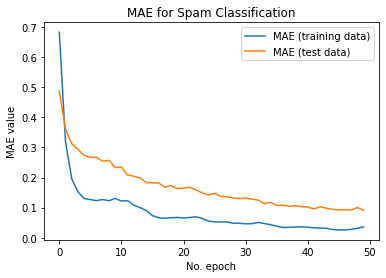

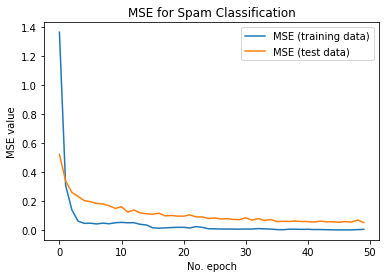

In [ ]:
###############
# STATS PLOTS #
###############

def plot_mae():
  plt.plot(hist['epoch'], hist['mae'], label='MAE (training data)')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'MAE (test data)')
  plt.title('MAE for Spam Classification')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper right")
  #plt.xlim([0,50])
  plt.show()

def plot_mse():
  plt.plot(hist['epoch'], hist['mse'], label='MSE (training data)')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'MSE (test data)')
  plt.title('MSE for Spam Classification')
  plt.ylabel('MSE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper right")
  #plt.xlim([0,50])
  plt.show()

plot_mae()
plot_mse()